In [1]:
import pandas as pd
from graph_traffic.merge_data import merge_data
from graph_traffic.get_data import get_mmagns
from graph_traffic.custom_transformer import get_column_names, transform_df
from graph_traffic.config import project_path
from graph_traffic.model_selection import get_node_ids
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

ids_to_use = get_node_ids()

data_dict = dict(
    ids_list=ids_to_use,  #[1001],#[3532, 3542, 3544, 3545, 3546, 3577, 3637, 3640, 3641, 4761, 4763],
    seq_len=4 * 24,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = {
    'rain': 'numerico_power',
    'wind': 'drop',
    'temperature': 'passthrough',
    'humidity': 'passthrough',
    'pressure': 'drop',
    'radiation': 'passthrough'
}
mmagns = get_mmagns(meteo_dict)

temporal_dict = {
    'year': 'passthrough',
    'season': 'ordinal',
    'month': 'passthrough',
    'day_of_month': 'passthrough',
    'weekday': 'drop',
    'hour': 'one_hot',
    'minute': 'drop',
    'bank_holiday': 'passthrough',
    'school_holiday': 'drop',
    'working_day': 'passthrough',
    'state_of_alarm': 'passthrough'
}

column_names = get_column_names(meteo_dict, temporal_dict, "drop", data_dict["target"])[1:]

with open(f"{project_path}/training_history/xgboost/bestparams.pkl", "rb") as f:
    best_params = pickle.load(f)

dfs_dict = {}
maes_per_sensor = {}
mses_per_sensor = {}
train_x = dict()
train_y = dict()
test_x = dict()
test_y = dict()

for node_id in ids_to_use:
    df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
    dfs_dict[node_id] = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])

for node_id in ids_to_use:
    print()
    print(node_id)
    maes_per_sensor[node_id] = dict()
    mses_per_sensor[node_id] = dict()
    for train_until in pd.date_range("2021-05-27", "2021-11-30", freq="1M"):
        print(train_until, end="\r")
        # all observations before or on 27th April 2021 are in the training
        train_data_size = dfs_dict[node_id][(dfs_dict[node_id][:, 28] <= 2020) |
                                            ((dfs_dict[node_id][:, 30] <= train_until.month) & (
                                                        dfs_dict[node_id][:, 31] <= train_until.day))].shape[0]
        test_data_size = dfs_dict[node_id][(dfs_dict[node_id][:, 28] >= 2020) &
                                           ((dfs_dict[node_id][:, 30] >= train_until.month) & (
                                                       dfs_dict[node_id][:, 31] >= train_until.day)) &
                                           ((dfs_dict[node_id][:, 30] <= train_until.month + 1) & (
                                                       dfs_dict[node_id][:, 31] <= 31))
                                           ].shape[0]
        train_x[node_id] = dfs_dict[node_id][:train_data_size, 1:]
        train_y[node_id] = dfs_dict[node_id][:train_data_size, 0].ravel()

        test_x[node_id] = dfs_dict[node_id][train_data_size:train_data_size + test_data_size, 1:]
        test_y[node_id] = dfs_dict[node_id][train_data_size:train_data_size + test_data_size, 0].ravel()

        reg = xgb.XGBRegressor(
            n_estimators=best_params["n_estimators"][node_id],
            max_depth=best_params["max_depth"][node_id],
            min_child_weight=best_params["min_child_weight"][node_id],
            gamma=best_params["gamma"][node_id],
            subsample=best_params["subsample"][node_id],
            colsample_bytree=best_params["colsample_bytree"][node_id],
            reg_alpha=best_params["reg_alpha"][node_id],
            reg_lambda=best_params["reg_lambda"][node_id],
            learning_rate=best_params["learning_rate"][node_id]
        )

        reg.fit(train_x[node_id], train_y[node_id])
        pred = reg.predict(test_x[node_id])
        maes_per_sensor[node_id][train_until] = mean_absolute_error(test_y[node_id], pred)
        mses_per_sensor[node_id][train_until] = mean_squared_error(test_y[node_id], pred)



C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



5126
2021-11-30 00:00:00
9847
2021-11-30 00:00:00
5045
2021-11-30 00:00:00
3685
2021-11-30 00:00:00
5046
2021-11-30 00:00:00
5125
2021-11-30 00:00:00
5061
2021-11-30 00:00:00
5122
2021-11-30 00:00:00
5245
2021-11-30 00:00:00
5047
2021-11-30 00:00:00
5055
2021-11-30 00:00:00
5054
2021-11-30 00:00:00
5108
2021-11-30 00:00:00
3686
2021-11-30 00:00:00
5052
2021-11-30 00:00:00
5050
2021-11-30 00:00:00
5051
2021-11-30 00:00:00
5048
2021-11-30 00:00:00
10025
2021-11-30 00:00:00
3576
2021-11-30 00:00:00
5105
2021-11-30 00:00:00
5121
2021-11-30 00:00:00
5044
2021-11-30 00:00:00
5120
2021-11-30 00:00:00
5049
2021-11-30 00:00:00
5118
2021-11-30 00:00:00
3628
2021-11-30 00:00:00
3572
2021-11-30 00:00:00
5114
2021-11-30 00:00:00
3684
2021-11-30 00:00:00
5102
2021-11-30 00:00:00
3481
2021-11-30 00:00:00
5100
2021-11-30 00:00:00
5119
2021-11-30 00:00:00
5101
2021-11-30 00:00:00
5099
2021-11-30 00:00:00
5109


In [2]:
with open(f"{project_path}/training_history/xgboost/maes.pkl", "wb") as f:
    pickle.dump(maes_per_sensor, f)

with open(f"{project_path}/training_history/xgboost/mses.pkl", "wb") as f:
    pickle.dump(mses_per_sensor, f)

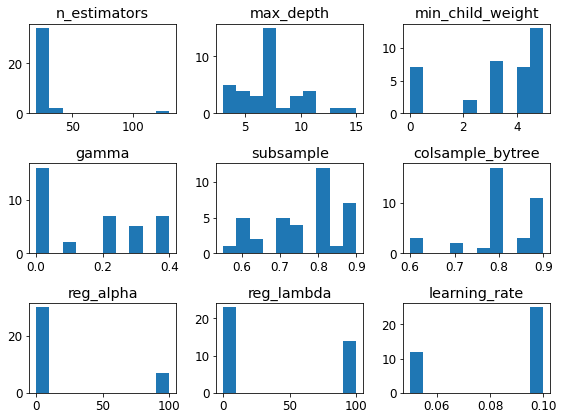

In [3]:
best_params = {k: v for (k, v) in best_params.items() if not k.endswith("1")}
fig, axs = plt.subplots(3, 3, figsize=(8, 3 * 2))
for i, (param, values) in enumerate(best_params.items()):
    row = i // 3
    column = i % 3
    ax = axs[row, column]
    ax.hist(values.values())
    ax.set_title(param)
#axs[-1, 1].axis("off")
#axs[-1, 2].axis("off")
fig.tight_layout()
fig.savefig(f"{project_path}/training_history/xgboost/parameters.png")

In [11]:
maes = pd.DataFrame(maes_per_sensor)
maes.index = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
maes = maes.T
maes["avg"] = maes.mean(axis=1)
maes["std"] = maes.std(axis=1)
maes = maes.round(4)
#maes = maes[["avg MAE", "std MAE"]].round(4)
maes.to_csv(f"{project_path}/training_history/xgboost/xgb_maes.csv")
maes

,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg,std
5126,6.8996,7.4763,6.9903,7.2942,7.8414,7.7308,9.2904,7.6461,0.7454
9847,4.6899,4.0150,3.4106,4.3769,4.8746,4.5473,4.8495,4.3948,0.4871
5045,1.4749,1.2375,1.5966,1.4315,2.0065,1.5629,2.2318,1.6488,0.3217
3685,1.8281,1.7625,1.4426,1.5325,2.1099,1.5824,2.0035,1.7517,0.2299
5046,2.4059,1.6503,1.2913,3.1530,3.6934,1.9043,2.4443,2.3632,0.7810
5125,6.3790,6.2174,6.3604,7.0468,7.2862,8.0610,7.6189,6.9957,0.6547
5061,1.8540,1.7741,1.3036,1.8390,2.5309,1.6682,1.9109,1.8401,0.3389
5122,1.8461,2.0869,2.6607,1.7007,1.7993,1.6052,1.7681,1.9239,0.3310
5245,22.0393,3.4744,1.4162,4.7687,7.4013,2.6533,4.4580,6.6016,6.5375
5047,1.7797,1.4185,1.0671,1.2746,2.2084,1.2688,1.6492,1.5238,0.3579


In [14]:
mses = pd.DataFrame(mses_per_sensor)
mses.index = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
mses = mses.T
mses["avg"] = mses.mean(axis=1)
mses["std"] = mses.std(axis=1)
#mses = mses[["avg MAE", "std MAE"]].round(4)
mses = mses.round(2)
mses.to_csv(f"{project_path}/training_history/xgboost/xgb_mses.csv")
mses

,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg,std
5126,84.33,101.14,89.30,90.71,115.92,104.13,159.07,106.37,23.67
9847,35.79,28.29,16.96,36.85,45.13,44.68,46.31,36.29,9.91
5045,3.20,2.52,4.40,4.14,22.57,4.21,11.12,7.45,6.71
3685,5.43,5.74,3.48,4.35,8.06,5.16,8.68,5.84,1.75
5046,12.78,6.83,4.92,36.52,40.53,9.55,15.03,18.02,13.38
5125,74.45,66.06,65.89,87.57,96.66,114.46,103.67,86.96,17.60
5061,6.06,6.19,3.27,6.26,15.15,5.76,7.34,7.15,3.46
5122,7.78,9.16,9.47,6.81,10.08,7.72,6.90,8.27,1.20
5245,1194.45,35.53,3.61,104.79,319.64,33.43,106.64,256.87,394.92
5047,8.06,4.31,1.81,2.92,33.42,3.57,8.21,8.90,10.27


In [13]:
df = pd.merge(maes[["avg", "std"]], mses[["avg", "std"]], left_index=True, right_index=True)
df.columns = ["Media MAE", "Desviación estándar MAE", "Media MSE", "Desviación estándar MSE"]
df.to_csv(f"{project_path}/training_history/xgboost/xgb_losses.csv")
df

,Media MAE,Desviación estándar MAE,Media MSE,Desviación estándar MSE
5126,7.6461,0.7454,106.3730,23.6734
9847,4.3948,0.4871,36.2880,9.9060
5045,1.6488,0.3217,7.4511,6.7087
3685,1.7517,0.2299,5.8434,1.7490
5046,2.3632,0.7810,18.0227,13.3834
5125,6.9957,0.6547,86.9643,17.5954
5061,1.8401,0.3389,7.1474,3.4620
5122,1.9239,0.3310,8.2743,1.1998
5245,6.6016,6.5375,256.8708,394.9233
5047,1.5238,0.3579,8.9013,10.2672
